In [5]:
import pandas as pd
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split

#plotting
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#modeling
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, InputLayer
from keras import optimizers, regularizers
from keras.applications import vgg16
import keras

# evaluation
from sklearn.metrics import confusion_matrix

# img augmentation
from skimage import exposure, transform
from skimage.util import random_noise
import random



2024-01-14 10:45:04.144727: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 10:45:04.512847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 10:45:05.584950: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
def plot_acur_loss(history, epochs_num, types, name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(types + ' CNN Performance', fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs_num+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs_num+1, 2))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_ylim([0.25,0.6])
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs_num+1, 2))
    ax2.set_ylabel('Loss Value')
    ax2.set_ylim([0,4])
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    
    #save
    if name != None:
        colab_path = name + '.png'
        path = '../Graphs/' + name + '.png'
        plt.savefig(colab_path)

def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

def confusion_matrix_heatmap(model, batch_s, X_test, y_test, name):
    '''
    A fucntion for plotting the confusion matrix

    Parameters
    ----------
    model : model to be tested
    y_test, X_test : test data

    Returns
    -------
    heatmap of confusion matrix and saves with specified name
    '''
    cats = ['beaches', 'entertainment', 'gardens/zoo', 'landmarks', 'museums',
       'parks']
    
    y_test = y_test.idxmax(axis=1)

    pred = model.predict(X_test, batch_size = batch_s)
    pred = pd.DataFrame(pred, columns = cats)

    # Get most likely class
    pred_classes = pred.idxmax(axis=1)

    #Get Confusion Matrix
    conf = confusion_matrix(y_test, pred_classes)

    #plot
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,10))
    sns.heatmap(conf, cmap=plt.cm.get_cmap('Blues'), annot=True, square=True, fmt='d', xticklabels=cats,
                   yticklabels=cats)

    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)
    plt.title('Confusion matrix', fontsize=25)

    #save
    if name != None:
        colab_path = name + '.png'
        path = '../Graphs/' + name + '.png'
        plt.savefig(colab_path)
        
def get_augmented_imgs_flip(X,y):
    X_aug = []
    y_aug = []

    for idx,img in enumerate(X):
        X_aug.append(np.fliplr(img))
        y_aug.append(y[idx])
        
    return (np.array(X_aug), np.array(y_aug))

def get_augmented_imgs_transform(X,y):
    X_aug = []
    y_aug = []

    for idx,img in enumerate(X):
        X_aug.append(transform.rotate(img, random.uniform(-30,30)))
        y_aug.append(y[idx])
        
    return (np.array(X_aug), np.array(y_aug))

def get_augmented_imgs_noise(X,y):
    X_aug = []
    y_aug = []

    for idx,img in enumerate(X):
        X_aug.append(random_noise(img, mode='s&p', clip=True))
        y_aug.append(y[idx])
        
    return (np.array(X_aug), np.array(y_aug))

def get_img_flip(img):
    
    return np.fliplr(img)

def get_img_transform(img):
    
    return transform.rotate(img, random.uniform(-30,30))

def get_img_noise(img):
    
    return random_noise(img, mode='s&p', clip=True)



load train data

In [7]:
X_train = np.load("pickle_files/X_train_clean.npz")['arr_0']

y_train = pd.read_pickle("pickle_files/Y_train_clean.pkl")

print(X_train.shape, y_train.shape)

(2739, 150, 150, 3) (2739,)


In [8]:
y_train.value_counts()

category
museums          1739
beaches           408
parks             237
landmarks         147
entertainment     125
gardens/zoo        83
Name: count, dtype: int64

Normalize Data

In [9]:
X_train_std = X_train / 255
X_train = np.load("pickle_files/X_train_clean.npz")['arr_0']

Augmented Data

In [10]:
y_train_aug = y_train.reset_index()
X_train_aug=X_train
y_train_aug.drop('index', axis=1, inplace=True)
# X_train_aug = []
# y_train_aug = []

# for idx in range(0,len(X_train_std)):
#     X_train_aug.append(X_train_std[idx])
#     X_train_aug.append(get_img_flip(X_train_std[idx]))
#     X_train_aug.append(get_img_transform(X_train_std[idx]))
#     X_train_aug.append(get_img_noise(X_train_std[idx]))
    
#     y_train_aug.append(y_train.iloc[idx,0])
#     y_train_aug.append(y_train.iloc[idx,0])
#     y_train_aug.append(y_train.iloc[idx,0])
#     y_train_aug.append(y_train.iloc[idx,0])

print(len(X_train_aug), len(y_train_aug))

2739 2739


One-Hot encode 

In [12]:
y_train_cat_aug = pd.get_dummies(y_train_aug)
y_train_cat = pd.get_dummies(y_train)

y_val = pd.read_pickle("pickle_files/Y_val_clean.pkl")
y_val_cat = pd.get_dummies(y_val)

print(y_train_cat_aug.shape, y_val_cat.shape)

(2739, 6) (913, 6)


In [13]:
# save X train augmented data in 2 parts
mid = len(X_train_aug)//2
np.savez_compressed('X_train_augA.npz', X_train_aug[:mid])
np.savez_compressed('X_train_augB.npz', X_train_aug[mid:])
# save y train augmented data
y_train_cat_aug.to_pickle('y_train_cat_aug.pkl')
y_val_cat.to_pickle('y_val_cat.pkl')

In [14]:
print(y_val_cat.shape)

(913, 6)


In [15]:
unique_labels = np.unique(y_val_cat)

print(unique_labels)


[False  True]


## Convolutional Neural Network (CNN)

In [17]:
n_classes = len(y_train_cat_aug.columns)
epochs_num = 9
inputs = (150, 150, 3)
print(n_classes)

6


### Basic CNN

In [18]:
X_val=np.load("pickle_files/X_val_clean.npz")['arr_0']
y_val_cat=pd.read_pickle("pickle_files/Y_val_clean.pkl")

print(X_val.shape)
print(y_val_cat.shape)

(913, 150, 150, 3)
(913,)


In [39]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Assuming your data preparation steps are something like this
# Replace this with your actual data preparation code

# For X_val
X_val = np.array(X_val)
X_val = X_val.reshape(-1, 150, 150, 1)  # Adjust the last dimension according to your data

# For y_val_cat
label_encoder = LabelEncoder()
y_val_cat_encoded = label_encoder.fit_transform(y_val_cat)
y_val_cat_one_hot = to_categorical(y_val_cat_encoded, num_classes=n_classes)

# Print shapes to check
print("X_val shape:", X_val.shape)
print("y_val_cat shape:", y_val_cat_one_hot.shape)

# Check number of samples in X_val and y_val_cat
if X_val.shape[0] != y_val_cat_one_hot.shape[0]:
    print("Error: Number of samples in X_val and y_val_cat do not match.")
else:
    print("Number of samples in X_val and y_val_cat match.")

# Check unique classes in y_val_cat
unique_classes_in_y = np.unique(y_val_cat)
expected_classes = np.unique(label_encoder.classes_)
if not np.array_equal(unique_classes_in_y, expected_classes):
    print("Error: Classes in y_val_cat do not match the expected classes.")
else:
    print("Classes in y_val_cat match the expected classes.")


X_val shape: (1359, 150, 150, 1)
y_val_cat shape: (453, 5)
Error: Number of samples in X_val and y_val_cat do not match.
Classes in y_val_cat match the expected classes.


In [41]:
import numpy as np

# Example array of labels

# Fetch unique label names
unique_labels = np.unique(y_train_cat_aug)

print(unique_labels)


[0 1]


In [43]:
# # from sklearn.preprocessing import LabelEncoder

# # label_encoder = LabelEncoder()
# # y_val_cat_encoded = label_encoder.fit_transform(y_val_cat)
# # from keras.utils import to_categorical

# # y_val_cat_one_hot = to_categorical(y_val_cat_encoded, num_classes=n_classes)


# # print(X_val.shape, y_val_cat.shape)
# # model = Sequential()

# # # convolutional layer
# # model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(inputs)))
# # model.add(MaxPooling2D(pool_size=(2, 2)))

# # # convolutional layer
# # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))

# # # convolutional layer
# # model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2, 2)))

# # # flatten output of conv
# # model.add(Flatten())

# # # hidden layers
# # model.add(Dense(512, activation='relu'))
# # model.add(Dense(n_classes, activation='sigmoid'))


# # model.compile(loss='categorical_crossentropy',
# #               optimizer=optimizers.RMSprop(),
# #               metrics=['accuracy'])

# # model.summary()

# # # history =  model.fit(X_train_aug, y_train_cat_aug, batch_size=50, epochs=epochs_num, validation_data=(X_val, y_val_cat), 
# # #                      verbose=1)

# # import numpy as np

# # X_train_aug = np.array(X_train_aug)
# # X_val = np.array(X_val)

# # # X_train_aug = X_train_aug.reshape(-1, 150, 150, 1)  # adjust the last dimension according to your data
# # # X_val = X_val.reshape(-1, 150, 150, 1)  # adjust the last dimension according to your data
# # print(X_val.shape)
# # print(y_val_cat.shape)



# # history = model.fit(X_train_aug, y_train_cat_aug, batch_size=50, epochs=epochs_num, validation_data=(X_val, y_val_cat), verbose=1)








# from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from keras import optimizers
# import numpy as np

# # Label Encoding and One-Hot Encoding for target labels
# label_encoder = LabelEncoder()
# y_val_cat_encoded = label_encoder.fit_transform(y_val_cat)
# n_classes = len(label_encoder.classes_)
# y_val_cat_one_hot = to_categorical(y_val_cat_encoded, num_classes=n_classes)

# # Assuming X_val is a NumPy array
# X_val = np.array(X_val)

# # Reshape input data
# X_val = X_val.reshape(-1, 150, 150, 3)  # Assuming your images are RGB (3 channels)

# # Print shapes
# print("X_val shape:", X_val.shape)
# print("y_val_cat_one_hot shape:", y_val_cat_one_hot.shape)

# # Build the CNN model
# model = Sequential()
# model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(n_classes, activation='sigmoid'))

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.RMSprop(),
#               metrics=['accuracy'])

# # Display the model summary
# model.summary()

# # Train the model
# history = model.fit(X_train_aug, y_train_cat_aug, batch_size=50, epochs=epochs_num, validation_data=(X_val, y_val_cat_one_hot), verbose=1)












from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras import optimizers
import numpy as np

# Assuming X_train_aug, y_train_cat_aug, X_val, y_val_cat are your training and validation data
# Adjust accordingly based on your actual data

# Label Encoding and One-Hot Encoding for target labels
label_encoder = LabelEncoder()
y_val_cat_encoded = label_encoder.fit_transform(y_val_cat)
n_classes = len(label_encoder.classes_)
y_val_cat_one_hot = to_categorical(y_val_cat_encoded, num_classes=n_classes)

# Assuming X_train_aug is a NumPy array
X_train_aug = np.array(X_train_aug)

# Reshape input data
X_train_aug = X_train_aug.reshape(-1, 150, 150, 3)  # Assuming your images are RGB (3 channels)

# Build the CNN model
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(n_classes, activation='sigmoid'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train_aug, y_train_cat_aug, batch_size=50, epochs=epochs_num, validation_data=(X_val, y_val_cat_one_hot), verbose=1)




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)     

In [44]:
model.save("history.h5")

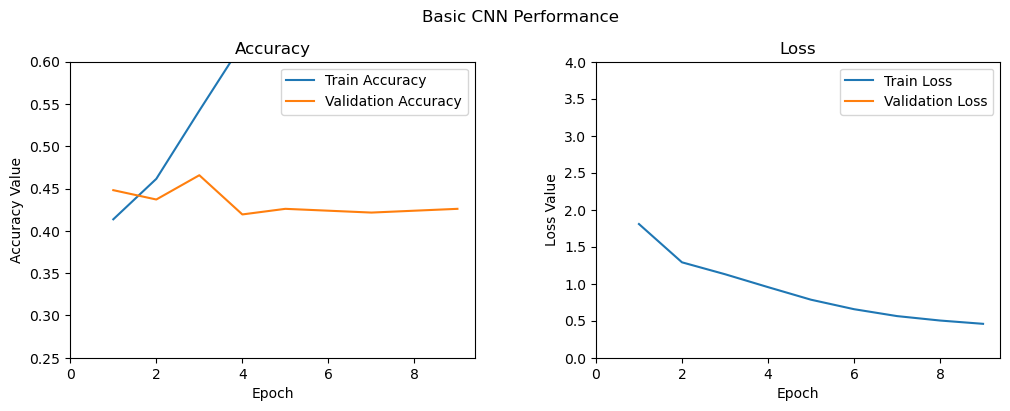

In [25]:
plot_acur_loss(history, epochs_num, 'Basic', None)

19/19 [==============================] - 3s 169ms/step


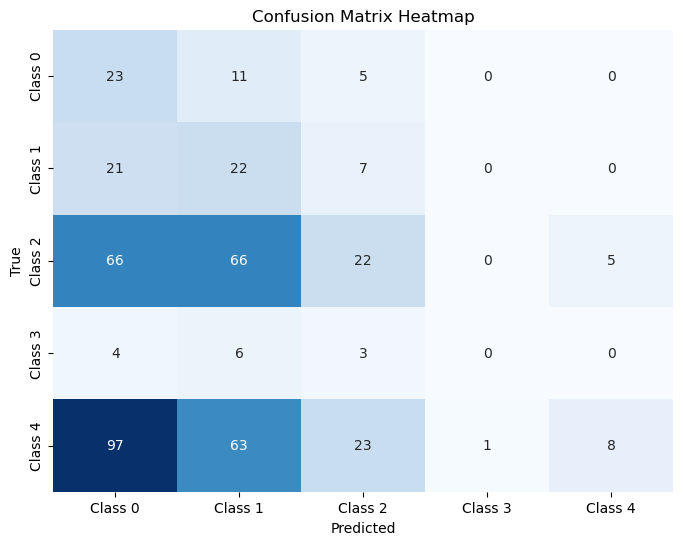

In [33]:
# confusion_matrix_heatmap(model, batch_s = 25, X_test = X_val, y_test = y_val_cat, name = None)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def confusion_matrix_heatmap(model, batch_s, X_test, y_test, name):
    '''
    A function for plotting the confusion matrix heatmap.

    Parameters:
    - model: The trained model
    - batch_s: Batch size for prediction
    - X_test: Test data
    - y_test: True labels for test data
    - name: Name for saving the plot (optional)
    '''
    
    # Get the predicted probabilities
    pred_probs = model.predict(X_test, batch_size=batch_s)
    
    # Get the predicted classes
    pred_classes = np.argmax(pred_probs, axis=1)
    
    # Get the true classes
    true_classes = np.argmax(y_test, axis=1)  # Directly use the NumPy array
    
    # Create a confusion matrix
    conf_matrix = confusion_matrix(true_classes, pred_classes)
    
    # Create a DataFrame for better visualization
    n_classes = len(np.unique(true_classes))
    class_labels = [f'Class {i}' for i in range(n_classes)]
    
    conf_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    
    # Save the plot if a name is provided
    if name:
        plt.savefig(name + '_confusion_matrix.png')
    
    plt.show()

# Example usage
confusion_matrix_heatmap(model, batch_s=25, X_test=X_val, y_test=y_val_cat_one_hot, name=None)



### CNN with Regularization

In [39]:
model = Sequential()

# model_reg.add(InputLayer(input_shape=(inputs)))

# convolutional layer
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(inputs)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# convolutional layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# convolutional layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3)) #regularization

# hidden layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3)) #regularization

model.add(Dense(n_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
model.summary()

history_reg = model.fit(X_train, y_train_cat, batch_size=30, epochs=epochs_num, validation_data=(X_val, y_val_cat), 
                            verbose=1)    

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 17, 17, 128)     

NameError: name 'y_train_cat' is not defined

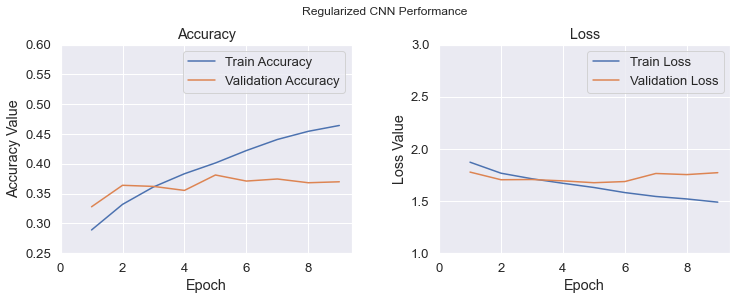

In [33]:
# model_reg.save('../Models/regularized_cnn.h5')
plot_acur_loss(history_reg, epochs_num, 'Regularized', None)

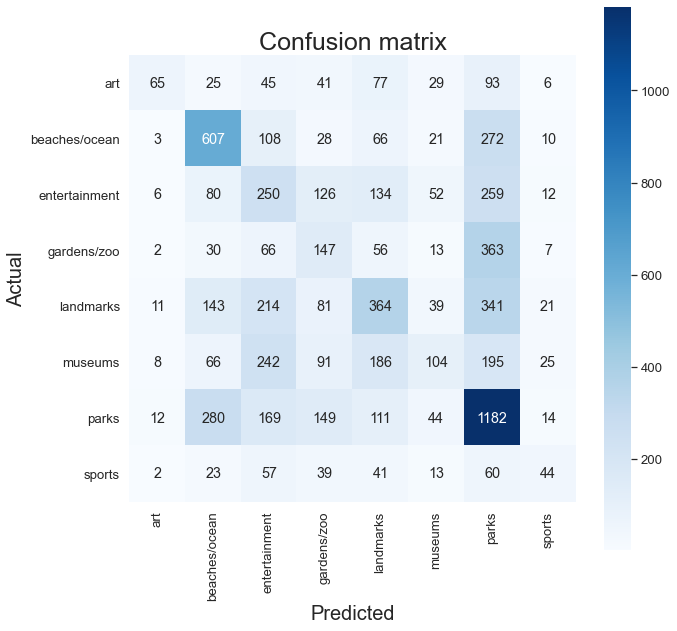

In [34]:
confusion_matrix_heatmap(model, batch_s = 30, X_test = X_val, y_test = y_val_cat, name = None)

### CNN with Transfer Learning using Pre-Trained VGG-16

Define VGG16 model and freeze layers

In [22]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=inputs)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

#dont want model weights to change durring training
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

#show layers
pd.set_option('max_colwidth', 1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_2, built=True>",input_layer_2,False
1,"<Conv2D name=block1_conv1, built=True>",block1_conv1,False
2,"<Conv2D name=block1_conv2, built=True>",block1_conv2,False
3,"<MaxPooling2D name=block1_pool, built=True>",block1_pool,False
4,"<Conv2D name=block2_conv1, built=True>",block2_conv1,False
5,"<Conv2D name=block2_conv2, built=True>",block2_conv2,False
6,"<MaxPooling2D name=block2_pool, built=True>",block2_pool,False
7,"<Conv2D name=block3_conv1, built=True>",block3_conv1,False
8,"<Conv2D name=block3_conv2, built=True>",block3_conv2,False
9,"<Conv2D name=block3_conv3, built=True>",block3_conv3,False


In [ ]:
# load X train data and get vgg features and save
X_train_vggB = get_bottleneck_features(vgg_model, np.load("X_train_augB.npz")['arr_0'] )
np.savez_compressed('X_train_vggB.npz',X_train_vggB)
X_train_vggA = get_bottleneck_features(vgg_model, np.load("X_train_augA.npz")['arr_0'] )
np.savez_compressed('X_train_vggA.npz',X_train_vggA)

# load X validateion data to get vgg features and save
X_val = np.load("pickle_files/X_val_clean.npz")['arr_0']
X_val_std = X_val/255
X_val_vgg = get_bottleneck_features(vgg_model, X_val_std )
np.savez_compressed('X_val_vgg.npz',X_val_vgg)

# print('Train Bottleneck Features:', X_train_vgg.shape, 
#       '\tValidation Bottleneck Features:', X_val_vgg.shape) 

In [ ]:
#load vgg data for modeling
X_train_vgg = np.concatenate([np.load('X_train_vggA.npz')['arr_0'], np.load('X_train_vggB.npz')['arr_0']])
X_val_vgg = np.load('X_val_vgg.npz')['arr_0']

y_train_cat_aug = pd.read_pickle('y_train_cat_aug.pkl')
y_val_cat = pd.read_pickle('y_val_cat.pkl')

In [ ]:
batch_s = 400
learning_rate = 0.00005
dropout = 0.55
epochs_num = 10
l2_loss_lambda = 0.00000001

l2 = regularizers.l2(l2_loss_lambda)

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(1000,  activation='relu',  kernel_regularizer=l2, input_dim=input_shape))
model.add(Dropout(dropout))
model.add(Dense(1000,  activation='relu',  kernel_regularizer=l2))
model.add(Dropout(dropout))
model.add(Dense(1000,  activation='relu',  kernel_regularizer=l2))
model.add(Dropout(dropout))
model.add(Dense(1000,  activation='relu',  kernel_regularizer=l2))
model.add(Dropout(dropout))
model.add(Dense(n_classes, activation='sigmoid', kernel_regularizer=l2))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['accuracy'])

model.summary()

history_vgg = model.fit(X_train_vgg, y_train_cat_aug, batch_size=batch_s, epochs=epochs_num, 
                            validation_data=(X_val_vgg, y_val_cat), verbose=1)

batch size: 400
learning rate: 5e-05
droupout: 0.55
epochs: 10
loss: 1e-08


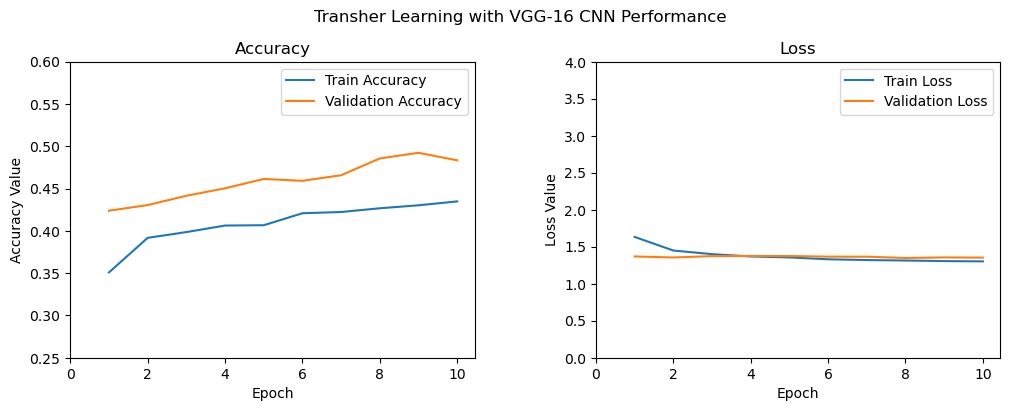

In [23]:
print('batch size: ' + str(batch_s))
print('learning rate: ' + str(learning_rate))
print('droupout: ' + str(dropout))
print('epochs: ' + str(epochs_num))
print('loss: ' + str(l2_loss_lambda))
      
plot_acur_loss(history_vgg, epochs_num, 'Transher Learning with VGG-16', 'vgg_acc')

In [26]:

# confusion_matrix_heatmap(model, batch_s = batch_s, X_test = X_val_vgg, y_test = y_val_cat, name = 'initial_vgg_cnn')


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def confusion_matrix_heatmap(model, batch_s, X_test, y_test, name):
    # Assuming your model predicts probabilities, convert them to class predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Assuming your ground truth labels are one-hot encoded, convert them to class labels
    y_true_classes = np.argmax(y_test, axis=1)

    # Create confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(cm.shape[1]), yticklabels=range(cm.shape[0]))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example usage
confusion_matrix_heatmap(model, batch_s=batch_s, X_test=X_val_vgg, y_test=y_val_cat, name='initial_vgg_cnn')



15/15 [==============================] - 0s 10ms/step


ValueError: Shape of passed values is (453, 1), indices imply (453, 5)

### Best results with CNN with Regularization and Transfer Learning

In [27]:
# model.save('../Models/vgg_cnn.h5')
# model.save('vgg_cnn.h5')
model.save('history_vgg.h5')

### Score Final Model on Test Data


In [28]:
#load test data
X_test = np.load('X_test_clean.npz')['arr_0']
X_test_std = X_test/255 #standardize
del X_test
X_test_vgg = get_bottleneck_features(vgg_model, X_test_std ) # get vgg features


y_test = pd.read_pickle('Y_test_clean.pkl')
y_test_cat = pd.get_dummies(y_test) # one hot encode

print(X_test_vgg.shape, y_test_cat.shape)

(453, 8192) (453, 5)


In [29]:
train_acc = model.evaluate(X_test_vgg, y_test_cat, verbose=0)
print(train_acc)

[1.3544353246688843, 0.46357616782188416]
